# University of Aberdeen

## Applied AI (CS5079)

### Lecture (Day 3) - Reinforcement Learning with OpenAI Gym

---

In the lecture, we introduce multiple reinforcement learning algorithms and test them on OpenAI Gym environments.

You can import OpenAI Gym by using the following code:

In [1]:
import gym

Because we use Codio, OpenAI Gym will not render graphical environments. We will only use the terminal `FrozenLakeNoSlip-v0` environment.

In [2]:
#We create and register our custom frozen lake environment
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import generate_random_map

try:
    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except:
    pass

#env_name = "FrozenLake-v0"
env_name = "FrozenLakeNoSlip-v0"
env = gym.make(env_name)

We will also use the following librairies:

In [3]:
#Librairies to represent the output
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

#Essential libraries for computation
import numpy as np
import random
import tensorflow.compat.v1 as tf
from collections import deque

## Environments

__Environments__ are test problems, offered by OpenAI Gym, for you to test reinforcement learning algorithms. 

In [4]:
#We can print the observation and action space
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Discrete(16)
Action space: Discrete(4)


The following code will pick and perform 100 actions at random. The environment is restarted each time the agent fallas into a hole

In [5]:
done = True
for _ in range(100):
    if done:
        current_obs = env.reset()
    next_obs, reward, done, info = env.step(env.action_space.sample()) # take a random action
    env.render()
    time.sleep(0.01)
    clear_output()
env.close()

## Agents & Q-table

The previous code does not create any agents. In the following cell, we will create an agent class able to learn using a Q-table.

In [6]:
class QAgent():
    def __init__(self, env, discount_rate=0.97, learning_rate=1):
        self.obs_size = env.observation_space.n
        self.action_size = env.action_space.n        
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.q_table = 1e-4*np.random.random([self.obs_size, self.action_size])

    #This will enable our agent to pick an action w.r.t. a given observation
    def get_action(self, current_obs):
        q_obs = self.q_table[current_obs]
        action_exploit = np.argmax(q_obs)
        action_random = random.choice(range(self.action_size))
        return action_random if random.random() < self.eps else action_exploit

    def train(self, experience):
        current_obs, action, next_obs, reward, done = experience
        q_next = self.q_table[next_obs]
        q_next = np.zeros([self.action_size]) if done else q_next
        q_target = reward + self.discount_rate * np.max(q_next)
        q_update = q_target - self.q_table[current_obs,action]
        self.q_table[current_obs,action] += self.learning_rate * q_update

        if done:
            self.eps = self.eps * 0.99

In [ ]:
agent = QAgent(env)
total_reward = 0
list_rewards=[]
for ep in range(500):
    current_obs = env.reset()
    done = False
    list_rewards.append(total_reward)
    while not done:
        action = agent.get_action(current_obs)
        next_obs, reward, done, info = env.step(action)
        agent.train((current_obs,action,next_obs,reward,done))
        current_obs = next_obs
        total_reward += reward
        print("Episode: {}, Total reward: {}, eps: {}".format(ep,total_reward,agent.eps))
        env.render()
        print(agent.q_table)
        time.sleep(0.01)
        clear_output(wait=True)
        

Episode: 74, Total reward: 13.0, eps: 0.475340042005707
  (Down)
SFFF
FHFH
FFFH
HFFG
[[8.32972005e-01 8.58734026e-01 8.07982845e-01 8.32972005e-01]
 [8.32972005e-01 0.00000000e+00 7.95033637e-05 8.07982845e-01]
 [7.71182627e-05 7.71182627e-05 8.19622306e-05 7.46398998e-05]
 [8.39735432e-05 0.00000000e+00 8.19622306e-05 8.44971449e-05]
 [8.58734026e-01 8.85292810e-01 0.00000000e+00 8.32972005e-01]
 [8.91056794e-05 1.77839995e-05 2.74779394e-05 2.62813450e-05]
 [0.00000000e+00 7.46733301e-05 0.00000000e+00 7.95033637e-05]
 [1.10110812e-05 1.87530684e-05 1.89363100e-05 5.63060623e-05]
 [8.85292810e-01 0.00000000e+00 9.12673000e-01 8.58734026e-01]
 [8.85292810e-01 9.40900000e-01 9.40900000e-01 0.00000000e+00]
 [9.12673000e-01 9.70000000e-01 0.00000000e+00 1.89127823e-05]
 [1.74938961e-05 9.71403142e-05 2.28786997e-05 4.24494613e-05]
 [4.17002119e-05 4.61688306e-05 9.44955051e-05 9.51544085e-05]
 [0.00000000e+00 9.40900000e-01 9.70000000e-01 9.12673000e-01]
 [9.40900000e-01 9.70000000e-01 1

<function matplotlib.pyplot.show>

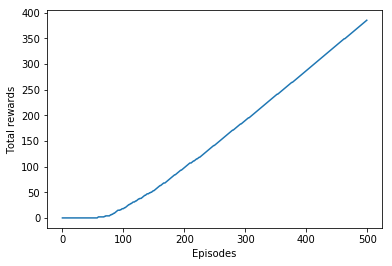

In [8]:
plt.plot(range(500), list_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total rewards')
plt.show

## Q-Learning with neural networks

In the following section, we show how to convert the Q-table into a dense layer.

In [ ]:
class QNNAgent():
    def __init__(self, env, discount_rate = 0.95, learning_rate = 0.01):
        self.observation_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        
        tf.reset_default_graph()
        tf.disable_eager_execution()
        
        #Input variables
        self.obs_in = tf.placeholder(tf.int32, shape=[1])
        self.target_in = tf.placeholder(tf.float32, shape=[1])
        self.action_in = tf.placeholder(tf.int32, shape=[1])
        
        #Transform into one-hot vectors
        self.obs = tf.one_hot(self.obs_in, depth=self.observation_size)
        self.action = tf.one_hot(self.action_in, depth = self.action_size)
        
        #This dense layer will replace the q-table
        self.q_obs = tf.layers.dense(self.obs, units= self.action_size, name="q_table")
        self.q_action = tf.reduce_sum(tf.multiply(self.q_obs, self.action), axis=1)
        
        #Loss function
        self.loss= tf.reduce_sum(tf.square(self.target_in - self.q_action))
        
        #Optimizer
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        
    def get_action(self, observation):
        q_obs = self.sess.run(self.q_obs, feed_dict={self.obs_in : [observation]})
        action_exploit = np.argmax(q_obs)
        action_random = random.choice(range(self.action_size))
        return action_random if random.random() < self.eps else action_exploit
    
    def train(self, current_obs, action, next_obs, reward, done):
        q_next = np.zeros([self.action_size]) if done else self.sess.run(self.q_obs, feed_dict={self.obs_in : [next_obs]})
        q_target = reward + self.discount_rate * np.max(q_next)
        
        feed = {self.obs_in : [current_obs], self.action_in: [action], self.target_in : [q_target]}
        self.sess.run(self.optimizer, feed_dict= feed)
        
        if done:
            self.eps = self.eps * 0.99
            
    def __del__(self):
        self.sess.close()
        

In [ ]:
agent = QNNAgent(env)
total_reward = 0
list_rewards=[]
for ep in range(500):
    current_obs = env.reset()
    done = False
    list_rewards.append(total_reward)
    while not done:
        action = agent.get_action(current_obs)
        next_obs, reward, done, info = env.step(action)
        agent.train(current_obs, action, next_obs, reward, done)
        current_obs = next_obs
        total_reward += reward
        print("Episode: {}, Total reward: {}, eps: {}". format(ep, total_reward, agent.eps))
        env.render()
        
        #We print the weights of the dense layer
        with tf.variable_scope("q_table", reuse=True):
            weights = agent.sess.run(tf.get_variable("kernel"))
            print(weights)
        time.sleep(0.01)
        clear_output(wait=True)

Episode: 499, Total reward: 368.0, eps: 0.006570483042414605
  (Right)
SFFF
FHFH
FFFH
HFFG
[[ 0.1394931   0.17162605  0.11659361  0.02643165]
 [ 0.15367384 -0.511191    0.00529074 -0.24440996]
 [ 0.11029028  0.12986273 -0.02828916  0.08272102]
 [ 0.13510734 -0.5741381   0.01730402  0.0631092 ]
 [ 0.17895907  0.21240185 -0.59198636  0.10004445]
 [-0.02290994  0.24929416  0.20486212  0.17972523]
 [-0.4888058   0.31031474 -0.4155228   0.03530838]
 [-0.3963793   0.35257822 -0.40063733  0.2631129 ]
 [ 0.22147614 -0.5930962   0.26538554  0.10129707]
 [ 0.22162925  0.3004659   0.30634525 -0.64311063]
 [ 0.20907904  0.3502522  -0.59114516  0.1067895 ]
 [-0.48135042  0.17995232 -0.15414649  0.10213578]
 [ 0.5324968  -0.5447055  -0.27145678  0.31972927]
 [-0.55557704  0.30813172  0.35805547  0.16700533]
 [ 0.29137644  0.35779712  0.40804118  0.23458825]
 [ 0.43027186 -0.45191765  0.3145721   0.30615276]]


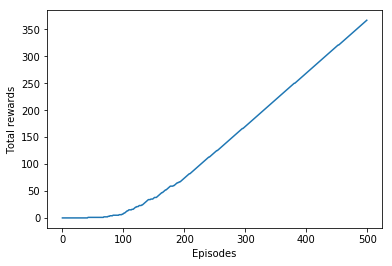

In [ ]:
plt.plot(range(500), list_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total rewards')
plt.show()

## Q-Learning with Experience Replay

We now add an experience buffer to store previous experiences. This will enable our agent to learn from previous experiences multiple times.

In [ ]:
class QNNAgentER():
    def __init__(self, env, discount_rate = 0.97, learning_rate = 0.001): #We reduced the learning rate
        self.observation_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        
        tf.reset_default_graph()
        tf.disable_eager_execution()
        
        #Input variables
        self.obs_in = tf.placeholder(tf.int32, shape=[None])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.target_in = tf.placeholder(tf.float32, shape=[None])
        
        #Transform into one-hot vectors
        self.obs = tf.one_hot(self.obs_in, depth = self.observation_size)
        self.action = tf.one_hot(self.action_in, depth = self.action_size)
        
        self.q_obs = tf.layers.dense(self.obs, units=self.action_size, name="q_table")
        self.q_action = tf.reduce_sum(tf.multiply(self.q_obs, self.action), axis=1)
        
        #Loss function
        self.loss= tf.reduce_sum(tf.square(self.target_in - self.q_action))
        
        #Optimizer
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        #Experience buffer
        self.replay_buffer = deque(maxlen=1000)
        
    def get_action(self, observation):
        q_obs = self.sess.run(self.q_obs, feed_dict={self.obs_in : [observation]})
        action_exploit = np.argmax(q_obs)
        action_random = random.choice(range(self.action_size))
        return action_random if random.random() < self.eps else action_exploit
    
    def train(self, experience, batch_size=50):
        #We store the new experience into the experience buffer
        self.replay_buffer.append(experience)
        
        #We extract an experience batch from the experience buffer
        samples = random.choices(self.replay_buffer, k=batch_size)
        current_obs, action, next_obs, reward, done = (list(col) for col in zip(experience,*samples))
        
        #We compute the q_target for the experiences in the batch
        q_next = self.sess.run(self.q_obs, feed_dict={self.obs_in: next_obs})
        q_next[done] = np.zeros([self.action_size])
        q_target = reward + self.discount_rate * np.max(q_next, axis=1)
        
        #We update the weights of the dense layer
        feed = {self.obs_in : current_obs, self.action_in: action, self.target_in : q_target}
        self.sess.run(self.optimizer, feed_dict = feed)
        
        if experience[4]:
            self.eps = self.eps * 0.99
            
    def __del__(self):
        self.sess.close()

In [ ]:
agent = QNNAgentER(env)
total_reward = 0
list_rewards=[]

for ep in range(500):
    current_obs = env.reset()
    done = False
    list_rewards.append(total_reward)
    while not done:
        action = agent.get_action(current_obs)
        next_obs, reward, done, info = env.step(action)
        agent.train((current_obs, action, next_obs, reward, done))
        current_obs = next_obs
        total_reward += reward
        print("Episode: {}, Total reward: {}, eps: {}". format(ep, total_reward, agent.eps))
        env.render()
        
        #We print the weights of the dense layer
        with tf.variable_scope("q_table", reuse=True):
            weights= agent.sess.run(tf.get_variable("kernel"))
            print(weights)
        time.sleep(0.01)
        clear_output(wait=True)

Episode: 499, Total reward: 354.0, eps: 0.006570483042414605
  (Right)
SFFF
FHFH
FFFH
HFFG
[[ 0.2968319   0.3291784   0.42602202  0.3312777 ]
 [ 0.2960946  -0.47057977  0.45243576  0.3523932 ]
 [ 0.3189321   0.43368602  0.37654254  0.390488  ]
 [ 0.35085642 -0.2693847   0.2951657   0.34609172]
 [ 0.28399003  0.30260298 -0.38072234  0.3400457 ]
 [ 0.33774716 -0.37992764  0.24035352  0.4536687 ]
 [-0.5215239   0.4619448  -0.41913646  0.32252184]
 [ 0.06018358  0.36539942 -0.4860709  -0.29735458]
 [ 0.05482299 -0.473626    0.23633975  0.31122202]
 [ 0.10334086  0.40594706  0.5088744  -0.01393639]
 [ 0.32537577  0.4909358  -0.42489284  0.4196993 ]
 [ 0.53592634 -0.4000732   0.30571324 -0.30173135]
 [ 0.31085837 -0.03507584  0.2544464  -0.3227734 ]
 [-0.4086607   0.39500722  0.32021987  0.42001376]
 [ 0.34369692  0.49031818  0.56722933  0.42264724]
 [-0.46932217  0.40719557 -0.09471896  0.49868655]]


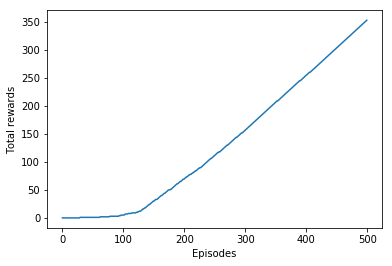

In [ ]:
plt.plot(range(500), list_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total rewards')
plt.show()

## Q-Learning with Prioritized Experience Replay

Instead of randomly picking an experience batch from the experience replay buffer, we will attach a priority to each experience based on the value of the error, i.e. the difference between the target value and the value returned by the q-table.

In [ ]:
class PrioritizedReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)
        
    #A new experience is given the maximum priority
    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))
        
    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def get_importance(self, probabilities):
        importance = 1/(len(self.buffer) *probabilities)
        importance_normalized = importance / max(importance)
        return importance_normalized
        
    def sample(self, batch_size, priority_scale=1.0):
        sample_size = min(len(self.buffer), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k=sample_size, weights=sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return map(list, zip(*samples)), importance, sample_indices
    
    def set_priorities(self, indices, errors, offset=0.001):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

In [ ]:
class QNNAgentPER():
    def __init__(self, env, discount_rate = 0.97, learning_rate = 0.001):
        self.observation_size = env.observation_space.n
        self.action_size = env.action_space.n
        
        self.eps = 1.0
        
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        
        tf.reset_default_graph()
        tf.disable_eager_execution()
        
        #Input variables
        self.obs_in = tf.placeholder(tf.int32, shape=[None])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.target_in = tf.placeholder(tf.float32, shape=[None])
        self.importance_in = tf.placeholder(tf.float32, shape=[None])
        
        #Transform into one-hot vectors
        self.obs = tf.one_hot(self.obs_in, depth = self.observation_size)
        self.action = tf.one_hot(self.action_in, depth = self.action_size)
        
        self.q_obs = tf.layers.dense(self.obs, units=self.action_size, name="q_table")
        self.q_action = tf.reduce_sum(tf.multiply(self.q_obs, self.action), axis=1)
        
        #Error
        self.error = self.target_in - self.q_action
        
        #Loss function
        self.loss= tf.reduce_mean(tf.multiply(tf.square(self.error), self.importance_in))
        
        #Optimizer
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        #Experience buffer
        self.replay_buffer = PrioritizedReplayBuffer(maxlen=1000)
        
    def get_action(self, observation):
        q_obs = self.sess.run(self.q_obs, feed_dict={self.obs_in : [observation]})
        action_exploit = np.argmax(q_obs)
        action_random = random.choice(range(self.action_size))
        return action_random if random.random() < self.eps else action_exploit
    
    def train(self, experience, batch_size=50, a = 0.0):
        #We add the new experience in the experience replay buffer
        self.replay_buffer.add(experience)
        
        #We get a sample from the experience replay buffer
        (current_obs, action, next_obs, reward, done),  importance, indices = self.replay_buffer.sample(batch_size, priority_scale = a)
        
        #We compute the q_targets for the experiences in the sample
        q_next = np.array(self.sess.run(self.q_obs, feed_dict={self.obs_in: next_obs}))
        q_next[list(map(bool,[int(d) for d in done]))] = np.zeros([self.action_size])
        q_target = reward + self.discount_rate * np.max(q_next, axis=1)
        
        #We update the weights of the dense layer
        feed = {self.obs_in : current_obs, self.action_in: action, self.target_in : q_target, self.importance_in: importance**(1 - self.eps)}
        self.sess.run(self.optimizer, feed_dict = feed)
        
        #We also need to update the priorities of the experiences that were in the sample
        self.replay_buffer.set_priorities(indices, self.sess.run(self.error, feed_dict=feed))
        
        if experience[4]:
            self.eps = max(0.1, self.eps * 0.995)
            
    def __del__(self):
        self.sess.close()
        
    

In [ ]:
num_runs = 10
run_rewards = []

for n in range(num_runs):
    list_rewards=[]
    agent = None
    agent = QNNAgentPER(env)
    num_episodes = 500
    total_reward= 0
    
    for ep in range(num_episodes):
        current_obs = env.reset()
        done = False
        while not done:
            action = agent.get_action(current_obs)
            next_obs, reward, done, info = env.step(action)
            agent.train((current_obs, action, next_obs, reward, done), batch_size=50, a=(n%2==0)*0.8)
            current_obs = next_obs
            total_reward += reward
            print("Run {}, Episode: {}, total_reward: {:.2f}, eps: {}".format(n,ep, total_reward, agent.eps))
            clear_output(wait=True)
        list_rewards.append(total_reward)
    run_rewards.append(list_rewards)

Run 8, Episode: 121, total_reward: 1.00, eps: 0.5452463540625918


In [ ]:
for n, ep_rewards in enumerate(run_rewards):
    col = "r" if (n%2==0) else "b"
    plt.plot(range(500), ep_rewards, color=col, label=n)

plt.xlabel('Episodes')
plt.ylabel('Total rewards')
plt.show